# Transformer Training

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

from transformer_model import *
import nltk
import sys
import matplotlib.pyplot as plt
sys.path.append("../../..")

from statapp.common.preprocessing import load_all_data, encode_data, split_into_X_y

from statapp.common.sampling import sample_token_sequence

import time

USE_CUDA = False


In [2]:
from transformer_model import *

### Selection GPU

In [3]:
USE_CUDA = True

In [4]:
import torch
torch.cuda.is_available()

True

## Preprocessing

Preprocessing maison assez brouillon pour le moment... L'encodage est effectué au niveau des mots. Les données exploitées sont placées dans le dossier data dans le dossier du notebook.

In [5]:
vocab_size = 10000

In [6]:
text = load_all_data("data/fr.train.top1M.txt", sample=0.001)

tokens = nltk.word_tokenize(text)

vocab = list(set(tokens))
vocab.sort()

In [7]:
dico = {}

for word in vocab:
    dico[word]=0
    
for token in tokens:
    dico[token]+=1
    
sorted_list = sorted(dico.items(), key=lambda x: x[1], reverse=True)

sorted_dico = {}

for i in range(min(len(sorted_list),vocab_size-1)):
    sorted_dico[sorted_list[i][0]] = sorted_list[i][1]

In [8]:
for i in range(len(tokens)):
    if tokens[i] not in sorted_dico:
        tokens[i] = "<unk>"

In [9]:
vocab = list(set(tokens))
vocab.sort()

if "<unk>" not in vocab:
    vocab.append("<unk>")
    
vocab_size = len(vocab)

vocab_numbers = dict(zip(vocab, range(0,len(vocab))))
vocab_numeroted = dict(zip(range(0,len(vocab)), vocab))
tokens_numbers = np.array([vocab_numbers[tokens[i]] for i in range(len(tokens))])

tokens_numbers_sequences = np.array([ tokens_numbers[i:i+max_length+1] for i in range(len(tokens_numbers)-max_length)])
tokens_numbers_sequences = torch.tensor(tokens_numbers_sequences , dtype=torch.int64)

nb_sequences =  tokens_numbers_sequences.shape[0]

print("Les données exploitées contiennent {} tokens (mots) au total.".format(len(tokens)))
print("La taille du vocabulaire ainsi constitué est de {}".format(vocab_size))

Les données exploitées contiennent 50344 tokens (mots) au total.
La taille du vocabulaire ainsi constitué est de 10000


In [10]:
#Constitution d'un jeu de test numéroté selon le vocabulaire du jeu d'entrainement

text_test = load_all_data("data/fr.train.top1M.txt", start=0.99999, sample=0.00001)

tokens_test = nltk.word_tokenize(text_test)

for i in range(len(tokens_test)):
    if tokens_test[i] not in vocab:
        tokens_test[i] = "<unk>"

tokens_numbers_test = np.array([vocab_numbers[tokens_test[i]] for i in range(len(tokens_test))])

tokens_numbers_sequences_test = np.array([ tokens_numbers_test[i:i+max_length+1] for i in range(len(tokens_numbers_test)-max_length)])
tokens_numbers_sequences_test = torch.tensor(tokens_numbers_sequences_test , dtype=torch.int64)

nb_sequences_test =  tokens_numbers_sequences_test.shape[0]

print("Les données de test exploitées contiennent {} tokens (mots) au total.".format(len(tokens_test)))

Les données de test exploitées contiennent 494 tokens (mots) au total.


In [11]:
if USE_CUDA:
    tokens_numbers_sequences.cuda()
    tokens_numbers_sequences_test.cuda()

## Apprentissage du modèle

In [12]:
LMtransformer = buildTransformer(vector_size, nb_decoders, nb_heads, head_size, ffn_hidden_size, vocab_size)
if USE_CUDA:
    LMtransformer.cuda()

#Correspond à utiliser l'entropie croisée puisque les sorties sont des log_softmax
#et l'entropie croisée = nll_loss(log_softmax(.), target)
criterion = nn.NLLLoss()
optimizer = optim.Adam(LMtransformer.parameters(), lr=0.01)

In [13]:
def train_model(nb_epochs, batch_size):
    
    #What is this ?? I don't remember. Make grad required ?
    LMtransformer.train()
    
    #pas pour l'affichage progressif de la loss
    step = max(1,((len(tokens)-max_length-1)/batch_size)//5)
    
    epochs_losses = []
    losses = []
    test_losses = []
    
    start = time.time()
    
    for epoch in range(nb_epochs):
        
        running_loss = 0
        
        randperm = torch.randperm(nb_sequences)
        randperm = randperm[:(nb_sequences//batch_size)*batch_size]
        batchs_indices = randperm.reshape(nb_sequences//batch_size, batch_size)
        
        for i, batch_indices in enumerate(batchs_indices):
            
            batch = (tokens_numbers_sequences[batch_indices]).cuda()
            optimizer.zero_grad()
            output = LMtransformer(batch[:,:-1])
            loss = criterion(output.reshape(-1, vocab_size), batch[:,1:].flatten())

            loss.backward()
            optimizer.step()
            
            test_loss = 0
            
            #Il faudrait adapter les affichages en fonction du nombre de batchs total
            running_loss += loss.item()
            if i % step == step-1:
                
                #Calcul de la loss sur les données de test
                """
                if USE_CUDA:
                    test_output = (LMtransformer(tokens_numbers_sequences_test[:,:-1])).cuda()
                    test_loss = criterion(test_output.reshape(-1, vocab_size), tokens_numbers_sequences_test[:,1:].flatten())
                else:
                    test_output = LMtransformer(tokens_numbers_sequences_test[:,:-1])  
                    test_loss = criterion(test_output.reshape(-1, vocab_size), tokens_numbers_sequences_test[:,1:].flatten())
                
                print('[%d, %5d] loss: %.3f ; test_loss : %.3f' %
                      (epoch + 1, i + 1, running_loss / step, test_loss))
                """
                
                print('[%d, %5d] loss: %.3f ' %
                      (epoch + 1, i + 1, running_loss / step))
                """
                
                """
                #stock pour affichage graphique
                epochs_losses.append(epoch-1+(i/((len(tokens)-max_length-1)/batch_size)))
                losses.append(running_loss / step)
                #test_losses.append(test_loss)
                
                running_loss = 0.
                
                end = time.time()
                print(end-start)
                
        plt.plot(epochs_losses, losses)
        #plt.plot(epochs_losses, test_losses)

Test d'overfitting sur un cas ultrasimplifié (5 tokens, longueur de séquence 1, 3 decoders, 2 heads) :
- En observant les sorties le modèle a bien appris et overfitte ! (loss à 0 au bout de 5-6 epochs) 

C:\Users\Christos\Desktop\Git\statapp_language_model\statapp\transformer\pytorch\transformer_model.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = (torch.tensor(torch.add(embedded, pos_encodings), dtype=torch.float32)).cuda()


[1,  1006] loss: 5.965 
27.485434532165527
[1,  2012] loss: 5.069 
54.08424115180969
[1,  3018] loss: 4.715 
80.49355554580688
[1,  4024] loss: 4.497 
107.49129509925842
[1,  5030] loss: 4.341 
134.4248173236847


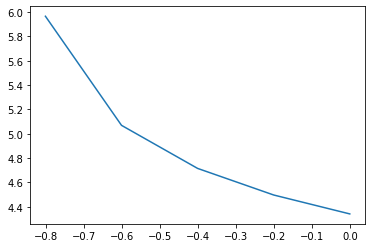

In [14]:
train_model(1,10)

## Sauvegarde des paramètres du modèle obtenu

In [15]:
#Un dico  des hyperparams serait pratique ^^
torch.save({
    "nb_decoders" : nb_decoders,
    "vector_size" : vector_size,
    "nb_heads" : nb_heads,
    "head_size" : head_size,
    "max_length" : max_length,
    "ffn_hidden_size" : ffn_hidden_size,
    "vocab_size" : vocab_size,
    "model_params_dict" : LMtransformer.state_dict()}
    ,
    "params/LMtfparamsTEST")
    #"params/LMtfparams"+str(np.random.rand())[2:])

In [8]:
#Later to restore:
lp = torch.load("params/LMtfparamsTEST")

nb_decoders = lp["nb_decoders"]
vector_size = lp["vector_size"]
nb_heads = lp["nb_heads"]
head_size = lp["head_size"]
max_length = lp["max_length"]
ffn_hidden_size = lp["ffn_hidden_size"]
vocab_size = lp["vocab_size"]
model_params_dict = lp["model_params_dict"]

LMtransformerTEST = buildTransformer(vector_size, nb_decoders, nb_heads, head_size, ffn_hidden_size, vocab_size)
LMtransformerTEST.load_state_dict(model_params_dict)

#Attention, pour pouvoir générer il faut reconstruire le vocabulaire et ses numéros associés avec le code plus haut

<All keys matched successfully>

## Génération

In [9]:
#bidouilles pour adapter nos fonctions aux fonctions common codées par Nathra 
#(sequence list of ints en entree, list of probas en sortie)
#(Faire mieux plus tard)
def LMtransformerprediction(listints):
    return np.exp(LMtransformer(torch.tensor([listints[-max_length:]]))[0][-1].tolist())

In [10]:
def LMtransformerpredictionTEST(listints):
    return np.exp(LMtransformerTEST(torch.tensor([listints[-max_length:]]))[0][-1].tolist())

In [11]:
def gen_seq(prev_seq, top_k=5):
    with torch.no_grad():
        prev_seq_numbers = [vocab_numbers[token] for token in prev_seq]
        sample_token_seq = sample_token_sequence(LMtransformerprediction, prev_seq_numbers, top_k=top_k)
        tokens_pred = [vocab_numeroted[i] for i in sample_token_seq]
        print(' '.join(tokens_pred)) 

In [12]:
def gen_seqTEST(prev_seq, top_k=5):
    with torch.no_grad():
        prev_seq_numbers = [vocab_numbers[token] for token in prev_seq]
        sample_token_seq = sample_token_sequence(LMtransformerpredictionTEST, prev_seq_numbers, top_k=top_k)
        tokens_pred = [vocab_numeroted[i] for i in sample_token_seq]
        print(' '.join(tokens_pred)) 

In [13]:
"""def gen_seq_maison(prev_seq):
    with torch.no_grad():
        prev_seq_numbers = [vocab_numbers[token] for token in prev_seq]
        indice = np.argmax(np.array(LMtransformer(torch.tensor([prev_seq_numbers]))))
        tokens_pred = vocab_numeroted[indice]
        print(' '.join(tokens_pred))"""

"def gen_seq_maison(prev_seq):\n    with torch.no_grad():\n        prev_seq_numbers = [vocab_numbers[token] for token in prev_seq]\n        indice = np.argmax(np.array(LMtransformer(torch.tensor([prev_seq_numbers]))))\n        tokens_pred = vocab_numeroted[indice]\n        print(' '.join(tokens_pred))"

In [14]:
gen_seqTEST(['il'], top_k=1)

  0%|                                                  | 0/100 [00:00<?, ?it/s]C:\Users\Eric\statapp_language_model\statapp\transformer\pytorch\transformer_model.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(torch.add(embedded, pos_encodings), dtype=torch.float32)
100%|████████████████████████████████████████| 100/100 [00:01<00:00, 96.97it/s]


est alors persuade d ' avoir atteint , par la meditation des lettres et des lettres et des nombres , l ' inspiration prophetique et l ' etat de 31 ans , a barcelone , il est touche par l ' esprit prophetique apres avoir obtenu la connaissance du vrai nom de dieu . il est alors persuade d ' avoir atteint , par la meditation des lettres et des lettres et des nombres , l ' inspiration prophetique et l ' etat de 31 ans , a barcelone , il est touche par l ' esprit prophetique apres avoir


In [18]:
gen_seq(['a','l','age','de','31','ans'])

  0%|                                                  | 0/100 [00:00<?, ?it/s]


NameError: name 'LMtransformer' is not defined

In [32]:
gen_seq(['<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>'], top_k=1)

100%|████████████████████████████████████████| 100/100 [00:01<00:00, 95.01it/s]


... en 1981 , mer . non content d ' exercer son sacerdoce , roger ducouret fut auteur de romans policiers , de contes pour enfants , brocanteur , ami d ' artistes comme pierre dac , fernand raynaud ou jacques brel ... il fut , l ' , les gens de maintenant de vitoria-gasteiz , dont l ' aeroport se met a se specialiser dans le traitement de charge aerienne et , formee par aena , la mairie de vitoria-gasteiz , dont l ' aeroport se met a se specialiser dans le traitement de charge aerienne et , formee


In [16]:
gen_seq(['barcelone',',','il','est','touche','par','l'])

100%|████████████████████████████████████████| 100/100 [00:01<00:00, 93.49it/s]


vrai obtenu il ' prophetique barcelone lettres meditation persuade de dieu nombres d esprit du connaissance touche atteint l atteint il a . la prophetique est age etat alors age etat alors age inspiration . ans atteint l vrai alors ans atteint des de avoir apres . la prophetique est age etat alors age inspiration . ans atteint l vrai alors ans atteint des de avoir apres . la prophetique est age etat alors age inspiration . ans atteint l vrai alors age inspiration . ans atteint l vrai alors age inspiration . ans atteint l vrai alors ans atteint


In [34]:
if len(tokens)<100:
    print(' '.join(tokens))